# LAB 01:  Applying Feature Engineering to BigQuery ML Models 

**Learning Objectives**

* Setup up the environment
* Create the project dataset
* Create the feature engineering training table
* Create and evaluate the  benchmark/baseline model
* Extract temporal features
* Perform a feature cross
* Evaluate model performance


## Introduction 
In this notebook, we utilize feature engineering to improve the prediction of the fare amount for a taxi ride in New York City.  We will use BigQuery ML to build a taxifare prediction model, using feature engineering to improve and create a final model.

In this lab we set up the environment, create the project dataset, create a feature engineering table, create and evaluate a benchmark model, extract temporal features, perform a feature cross and evaluate model performance.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solution/feateng-solution_bqml.ipynb). **NOTE TO SELF**:  UPDATE HYPERLINK.

### Set up environment variables and load necessary libraries

In [47]:
%%bash
export PROJECT=$(gcloud config list project --format "value(core.project)")
echo "Your current GCP Project Name is: "$PROJECT

Your current GCP Project Name is: cloud-training-demos


In [48]:
import os

PROJECT = "cloud-training-demos" # REPLACE WITH YOUR PROJECT NAME
REGION = "us-west1-b" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["BUCKET"] = PROJECT # DEFAULT BUCKET WILL BE PROJECT ID

if PROJECT == "your-gcp-project-here":
  print("Don't forget to update your PROJECT name! Currently:", PROJECT)

Check that the Google BigQuery library is installed and if not, install it. 

In [ ]:
!pip freeze | grep google-cloud-bigquery==1.6.1 || pip install google-cloud-bigquery==1.6.1

## The source dataset

Our dataset is hosted in [BigQuery](https://cloud.google.com/bigquery/). The taxi fare data is a publically available dataset, meaning anyone with a GCP account has access. Click [here](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=nyc-tlc&d=yellow&t=trips&page=table) to acess the dataset.

The Taxi Fare dataset is relatively large at 55 million training rows, but simple to understand, with only 6 features. The fare_amount is the target, the continuous value we’ll train a model to predict.


## Create a BigQuery Dataset and Google Cloud Storage Bucket 

A BigQuery dataset is a container for tables, views, and models built with BigQuery ML. Let's create one called __feat_eng__ if we have not already done so in an earlier lab. We'll do the same for a GCS bucket for our project too.

In [75]:
%%bash

## Create a BigQuery dataset for feat_eng_TEST if it doesn't exist
datasetexists=$(bq ls -d | grep -w feat_eng)

if [ -n "$datasetexists" ]; then
    echo -e "BigQuery dataset already exists, let's not recreate it."

else
    echo "Creating BigQuery dataset titled: feat_eng"
    
    bq --location=US mk --dataset \
        --description 'Taxi Fare' \
        $PROJECT:feat_eng
   echo "\nHere are your current datasets:"
   bq ls
fi    
    
## Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${PROJECT}/)

if [ -n "$exists" ]; then
   echo -e "Bucket exists, let's not recreate it."
    
else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${PROJECT}
   echo "\nHere are your current buckets:"
   gsutil ls
fi

BigQuery dataset already exists, let's not recreate it.
Bucket exists, let's not recreate it.


## Create the training data table

Since there is already a publicly available dataset, we can simply create the training data table using this raw input data.  Note the WHERE clause in the below query:  This clause allows us to TRAIN a portion of the data (e.g. one million rows versus a billion rows), which keeps your query costs down. 

* Note:  The dataset in the create table code below is the one created previously, e.g. "feat_eng".  The table name is "feateng_training_data".

#### **Exercise**:   **RUN** the query to create the table.

In [76]:
%%bigquery
CREATE OR REPLACE TABLE feat_eng.feateng_training_data 
AS
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  passenger_count*1.0 AS passengers,
  pickup_datetime,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat


FROM `nyc-tlc.yellow.trips`
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 10000) = 1
 
  AND fare_amount >= 2.5
  AND passenger_count > 0
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  
 

""


## Verify table creation

Verify that you created the dataset.


In [154]:
%%bigquery
-- LIMIT 0 is a free query; this allows us to check that the table exists.
SELECT * FROM feat_eng.feateng_training_data 
LIMIT 0

,fare_amount,passengers,pickup_datetime,pickuplon,pickuplat,dropofflon,dropofflat


### Benchmark Model:  Create the benchmark/baseline Model

Next, you create a linear regression baseline model with no feature engineering.  Recall that a model in BigQuery ML represents what an ML system has learned from the training data.  A baseline model is a solution to a problem without applying any machine learning techniques.  

When creating a BQML model, you must specify the model type (in our case linear regression) and the input label (fare_amount).  Note also that we are using the training data table as the data source.

#### Exercise:  Create the SQL statement to create the model "Benchmark Model".

In [ ]:
%%bigquery
# TODO: 

In [84]:
%%bigquery
# SOLUTION
CREATE OR REPLACE MODEL feat_eng.benchmark_model

OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS

SELECT 
 fare_amount,
  passengers,
  pickup_datetime,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat FROM feat_eng.feateng_training_data

""



REMINDER:  The query takes several minutes to complete. After the first iteration is complete, your model (benchmark_model) appears in the navigation panel of the BigQuery web UI. Because the query uses a CREATE MODEL statement to create a model, you do not see query results.

You can observe the model as it's being trained by viewing the Model stats tab in the BigQuery web UI. As soon as the first iteration completes, the tab is updated. The stats continue to update as each iteration completes.

Once the training is done, visit the [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) and look at the model that has been trained. Then, come back to this notebook.

### Evaluate the benchmark model
Note that BigQuery automatically split the data we gave it, and trained on only a part of the data and used the rest for evaluation.  After creating your model, you evaluate the performance of the regressor using the ML.EVALUATE function. The ML.EVALUATE function evaluates the predicted values against the actual data.

NOTE: The results are also displayed in the [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) under the **Evaluation** tab.

#### Exercise: Review the learning and eval statistics for the benchmark_model.

In [115]:
%%bigquery
#Eval statistics on the held out data.
SELECT *, SQRT(loss) AS rmse FROM ML.TRAINING_INFO(MODEL feat_eng.benchmark_model)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,0,74.434806,68.880152,None,13164,8.627561


In [112]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.benchmark_model)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.213535,68.880152,0.258107,3.790249,0.226068,0.226133


**NOTE:** Because you performed a linear regression, the results include the following columns:

*   mean_absolute_error
*   mean_squared_error
*   mean_squared_log_error
*   median_absolute_error
*   r2_score
*   explained_variance

**Resource** for an explanation of the regression metrics:  [Regression Metrics](https://https://joshlawman.com/metrics-regression/)

**Mean squared error** (MSE) - Measures the difference between the values our model predicted using the test set and the actual values. You can also think of it as the distance between your regression (best fit) line and the predicted values. 

**Root mean squared error** (RMSE) - The primary evaluation metric for this ML problem is the root mean-squared error. RMSE measures the difference between the predictions of a model, and the observed values. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better. One nice property of RMSE is that the error is given in the units being measured, so you can tell very directly how incorrect the model might be on unseen data.

**R2**:  An important metric in the evaluation results is the R2 score. The R2 score is a statistical measure that determines if the linear regression predictions approximate the actual data. 0 indicates that the model explains none of the variability of the response data around the mean. 1 indicates that the model explains all the variability of the response data around the mean.

#### Exercise: Write a SQL query to take the SQRT() of the mean squared error as your loss metric for evaluation for the benchmark_model.

In [ ]:
%%bigquery
# TODO 

In [110]:
%%bigquery
#SOLUTION
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.benchmark_model)


,rmse
0,8.299407


#### Model 1:  EXTRACT DayOfWeek from the pickup_datetime feature.

* As you recall, DayOfWeek is an enum representing the 7 days of the week. This factory allows the enum to be obtained from the int value. The int value follows the ISO-8601 standard, from 1 (Monday) to 7 (Sunday). 

#### Exercise:  EXTRACT DayOfWeek from the pickup_datetime feature.
* Create a model titled "model_1" from the benchmark model and extract out the DayofWeek.

In [ ]:
# TODO

In [103]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.model_1

OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS

SELECT 
 fare_amount,
  passengers,
  pickup_datetime,
  EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat FROM feat_eng.feateng_training_data

""


Once the training is done, visit the [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) and look at the model that has been trained. Then, come back to this notebook.

#### Exercise: Create two distinct SQL statements to see the TRAINING and EVALUATION metrics of model_1.

In [ ]:
#Create the SQL statements to extract Model_1 TRAINING metrics.  
# TODO: Your code goes here

In [ ]:
#Create the SQL statements to extract Model_1 EVALUATION metrics.  
# TODO: Your code goes here

In [104]:
%%bigquery
SELECT *, SQRT(loss) AS rmse FROM ML.TRAINING_INFO(MODEL feat_eng.model_1)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,0,72.440724,88.953232,None,17251,8.511212


In [108]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_1)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.287076,88.953232,0.260932,3.713439,0.08481,0.084811


#Create the SQL statements to review model_1 training information.  

#### Exercise: Write a SQL query to take the SQRT() of the mean squared error as your loss metric for evaluation for model_1.

In [ ]:
#Create the SQL statement to EVALUATE Model_1 here.  
# TODO: Your code goes here

In [117]:
%%bigquery
#SOLUTION
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_1)

,rmse
0,9.431502


### Model 2:  EXTRACT hourofday from the pickup_datetime feature

As you recall, **pickup_datetime** is stored as a TIMESTAMP, where the Timestamp format is retrieved in the standard output format – year-month-day hour:minute:second (e.g. 2016-01-01 23:59:59).  Hourofaday returns the integer number representing the hour number of the given date.

#### Exercise:  EXTRACT hourofday from the pickup_datetime feature.
* Create a model titled "model_2"
* EXTRACT the hourofday from the pickup_datetime feature to improve our model's rmse.

In [ ]:
# TODO: 

In [121]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.model_2
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
  
FROM `feat_eng.feateng_training_data`

""


#### Exercise:  Create two SQL statements to evaluate the model.

In [ ]:
# TODO: Your code goes here

In [ ]:
# TODO: Your code goes here

In [122]:
%%bigquery
#SOLUTION
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_2)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.256421,70.709518,0.262399,3.895509,0.236668,0.236768


In [123]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_2)

,rmse
0,8.408895


# LAB 02:  Applying Feature Engineering to BigQuery ML Models 

**Learning Objectives**

* Perform a feature cross
* Perform a feature cross using BigQuery's ML.FEATURE CROSS
* Derive coordinate features
* Feature cross coordinate features
* Evaluate model performance
* Code cleanup


## Introduction 
In this notebook, we perform a feature cross, derive coordinate features, feature cross coordinate features, evaluate model performance, and cleanup the code.


### Model 3:  Feature cross dayofweek and hourofday 

First, let’s allow the model to learn traffic patterns by creating a new feature that combines the time of day and day of week (this is called a feature cross). 

* Modify model_2 to create a feature cross that combines the time of day and day of week.  Note:  CAST DAYOFWEEK and HOUR as strings.  Name the model "model_3".  

* In this lab, we will modify the SQL to first use the CONCAT function to concatenate (feature cross) the dayofweek and hourofday features.  Then, we will use the ML.FEATURE_CROSS, BigQuery's new pre-processing feature cross function.

Note:  BQML by default assumes that numbers are numeric features, and strings are categorical features.  We need to convert these features to strings because the Neural Network will treat 1,2,3,4,5,6,7 as numeric values.  Thus, there is no way to distinguish the time of day and day of week "numerically."


#### Exercise: Create the SQL statement to feature cross the dayofweek and hourofday using the CONCAT function.

In [ ]:
# TODO: Your code goes here

In [124]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.revised_model_3
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING), 
        CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
  
FROM `feat_eng.feateng_training_data`

""


#### Exercise:  Create two SQL statements to evaluate the model. 

In [4]:
%%bigquery
#SOLUTION
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_3)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.500029,93.260577,0.27445,3.811464,0.080263,0.080492


In [5]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_3)

,rmse
0,9.657152


### Model 4:  Apply the ML.FEATURE_CROSS clause to categorical features

BigQuery ML now has ML.FEATURE_CROSS, a pre-processing clause that performs a feature cross.  

* ML.FEATURE_CROSS generates a STRUCT feature with all combinations of crossed categorical features, except for 1-degree items (the original features) and self-crossing items.  

* Syntax:  ML.FEATURE_CROSS(STRUCT(features), degree)

* The feature parameter is a categorical features separated by comma to be crossed. The maximum number of input features is 10. Unnamed feature is not allowed in features. Duplicates are not allowed in features.

* Degree(optional): The highest degree of all combinations. Degree should be in the range of [1, 4]. Default to 2.

Output: The function outputs a STRUCT of all combinations except for 1-degree items (the original features) and self-crossing items, with field names as concatenation of original feature names and values as the concatenation of the column string values.

#### Exercise:  The ML.Feature_Cross statement contains errors. Correct the errors and run the query.

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL feat_eng.model_4
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  #CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING), 
        #CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
  ML.FEATURE_CROSS(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING),
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
  
FROM `feat_eng.feateng_training_data`


In [18]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.model_4
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  #CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING), 
        #CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
 ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
  
FROM `feat_eng.feateng_training_data`


""


#### Exercise:  Create two SQL statements to evaluate the model.

In [19]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_4)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.500029,93.260577,0.27445,3.807548,0.080263,0.080492


In [20]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_4)

,rmse
0,9.657152


# LAB 03:  Applying Feature Engineering to BigQuery ML Models

**Learning Objectives**






### Model 5:  Feature cross coordinate features to create a Euclidean feature


Pickup coordinate:
*  pickup_longitude AS pickuplon
*  pickup_latitude AS pickuplat
 


Dropoff coordinate:
*   #dropoff_longitude AS dropofflon
*   #dropoff_latitude AS dropofflat

**NOTES**:
* The pick-up and drop-off longitude and latitude data are crucial to predicting the fare amount as fare amounts in NYC taxis are largely determined by the distance traveled.  Assuch, we need to  teach the model the Euclidean distance between the pick-up and drop-off points.  

* Recall that latitude and longitude allows us to specify any location on Earth using a set of coordinates.  In our training data set, we restricted our data points to only pickups and drop offs within NYC. NYC has an approximate longitude range of -74.05 to -73.75 and a latitude range of 40.63 to 40.85.

* The dataset contains information regarding the pickup and drop off coordinates. However, there is no information regarding the distance between the pickup and drop off points. Therefore, we create a new feature that calculates the distance between each pair of pickup and drop off points. We can do this using the Euclidean Distance, which is the straight-line distance between any two coordiante points.

* We need to convert those coordinates into a single column of a spatial data type.  We will use the The ST_Distance function, which returns the minimum distance between two spatial objects.  


#### Exercise:  Derive a coordinate feature.

* Convert the feature coordinates into a single column of a spatial data type. Use the The ST_Distance function, which returns the minimum distance between two spatial objects.
SAMPLE CODE:
ST_Distance(ST_GeogPoint(value1,value2), ST_GeogPoint(value3, value4)) AS euclidean




In [ ]:
# TODO

In [21]:
%%bigquery
#Solution
CREATE OR REPLACE MODEL feat_eng.model_5
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  #CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING), 
        #CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  #pickuplon,
  #pickuplat,
  #dropofflon,
  #dropofflat,
  ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) 
  AS euclidean
  
FROM `feat_eng.feateng_training_data`

""


#### Exercise:  Create two SQL statements to evaluate the model. 

In [ ]:
  # TODO: Your code goes here

In [22]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_5)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,3.121311,31.229717,0.106923,2.218179,0.661492,0.661507


In [23]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_5)

,rmse
0,5.588356


### Model 6:  Feature cross  pick-up and drop-off locations features

In this section, we feature cross the pick-up and drop-off locations so that the model can learn pick-up-drop-off pairs that will require tolls.

This step takes the geographic point corresponding to the pickup point and grids to a 0.1-degree-latitude/longitude grid (approximately 8km x 11km in New York—we should experiment with finer resolution grids as well). Then, it concatenates the pickup and dropoff grid points to learn “corrections” beyond the Euclidean distance associated with pairs of pickup and dropoff locations.

Because the lat and lon by themselves don't have meaning, but only in conjunction, it may be useful to treat the fields as a pair instead of just using them as numeric values. However, lat and lon are continuous numbers, so we have to discretize them first. That's what SnapToGrid does. 

**REMINDER**: The ST_GEOGPOINT creates a GEOGRAPHY with a single point. ST_GEOGPOINT creates a point from the specified FLOAT64 longitude and latitude parameters and returns that point in a GEOGRAPHY value.  The ST_Distance function returns the minimum distance between two spatial objectsa.  It also returns meters for geographies and SRID units for geometrics.  

#### Excercise:  The following SQL statement is incorrect.  Modify the code to feature cross the pick-up and drop-off locations features. 

In [ ]:
%%bigquery
#TODO 
CREATE OR REPLACE MODEL feat_eng.model_6
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  #CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING), 
        #CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  #pickuplon,
  #pickuplat,
  #dropofflon,
  #dropofflat,
 ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickuplat,pickuplon,pickuplat), 0.05)), 
 ST_AsText(ST_GeogPoint(dropofflon, dropofflat,dropofflon), 0.04)) AS pickup_and_dropoff
  
FROM `feat_eng.feateng_training_data`


In [142]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.model_6
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  #pickuplon,
  #pickuplat,
  #dropofflon,
  #dropofflat,
  ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) 
  AS euclidean,
   CONCAT(ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickuplon, pickuplat), 0.01)),
     ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropofflon, dropofflat), 0.01)))
  AS pickup_and_dropoff
  
FROM `feat_eng.feateng_training_data`

""


#### Exercise:  Create two SQL statements to evaluate the model.

In [7]:
%%bigquery
#SOLUTION
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_6)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.678752,34.885692,0.088598,1.485065,0.640979,0.642637


In [144]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_6)

,rmse
0,5.906411


### Code Clean Up

#### Exercise:  Clean up the code to see where we are

Remove all the commented statements in the SQL statement.  We should now have a total of five input features for our model.  
1. fare_amount
2. passengers
3. day_hr
4. euclidean
5. pickup_and_dropoff

In [24]:
%%bigquery
#Solution
CREATE OR REPLACE MODEL feat_eng.model_6
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) 
  AS euclidean,
   CONCAT(ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickuplon, pickuplat), 0.01)),
     ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropofflon, dropofflat), 0.01)))
  AS pickup_and_dropoff
  
FROM `feat_eng.feateng_training_data`

""


# LAB 03:  Applying Feature Engineering to BigQuery ML Models

**Learning Objectives**

* Apply the BUCKETIZE function
* Apply the TRANSFORM clause
* Apply L2 Regularization
* Model evaluation


## Introduction 
In this notebook, we apply the BUCKETIZE function, the TRANSFORM clause, L2 Regularization, and perform model evaluation.

## BQML's Pre-processing functions:

Here are some of the preprocessing functions in BigQuery ML:
* ML.FEATURE_CROSS(STRUCT(features))    does a feature cross of all the combinations
* ML.POLYNOMIAL_EXPAND(STRUCT(features), degree)    creates x, x^2, x^3, etc.
* ML.BUCKETIZE(f, split_points)   where split_points is an array 

### Model 7:  Apply the BUCKETIZE Function 


##### BUCKETIZE 
Bucketize is a pre-processing function that creates "buckets" (e.g bins) - e.g. it bucketizes a continuous numerical feature into a string feature with bucket names as the value.

* ML.BUCKETIZE(feature, split_points)

* feature: A numerical column.

* split_points: Array of numerical points to split the continuous values in feature into buckets. With n split points (s1, s2 … sn), there will be n+1 buckets generated. 

* Output: The function outputs a STRING for each row, which is the bucket name. bucket_name is in the format of bin_<bucket_number>, where bucket_number starts from 1.

* Currently, our model uses the ST_GeogPoint function to derive the pickup and dropoff feature.  In this lab, we use the BUCKETIZE function to create the pickup and dropoff feature.

#### Exercise: Apply the BUCKETIZE function.
* Hint:  Create a model_7.

In [ ]:
#TODO 

In [1]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.model_7
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #SQRT( (pickuplon-dropofflon)*(pickuplon-dropofflon) + (pickuplat-dropofflat)*(pickuplat-dropofflat) ) AS euclidean, 
  ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) AS euclidean,
    ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  CONCAT(
     ML.BUCKETIZE(pickuplon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(pickuplat, GENERATE_ARRAY(37, 45, 0.01)),
     ML.BUCKETIZE(dropofflon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(dropofflat, GENERATE_ARRAY(37, 45, 0.01))
  ) AS pickup_and_dropoff
  
FROM `feat_eng.feateng_training_data`

""


#### Exercise:  Create three SQL statements to EVALUATE the model.

In [2]:
%%bigquery
SELECT *, SQRT(loss) AS rmse FROM ML.TRAINING_INFO(MODEL feat_eng.model_7)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,3,11.231835,33.172360,0.4,6434,3.351393
1,0,2,13.263899,35.919936,0.8,5898,3.641964
2,0,1,20.108475,36.559006,0.4,6533,4.484247
3,0,0,70.490524,81.719679,0.2,3746,8.395864


In [3]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_7)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.674187,33.17236,0.089913,1.51821,0.635728,0.637299


In [4]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_7)

,rmse
0,5.759545


### Final Model:  Apply the TRANSFORM clause and L2 Regularization

Before we perform our prediction, we should encapsulate the entire feature set in a TRANSFORM clause.  BigQuery ML now supports defining data transformations during model creation, which will be automatically applied during prediction and evaluation. This is done through the TRANSFORM clause in the existing CREATE MODEL statement. By using the TRANSFORM clause, user specified transforms during training will be automatically applied during model serving (prediction, evaluation, etc.) 

In our case, we are using the TRANSFORM clause to separate out the raw input data from the TRANSFORMED features.  The input columns of the TRANSFORM clause is the query_expr (AS SELECT part).  The output columns of TRANSFORM from select_list are used in training. These transformed columns are post-processed with standardization for numerics and one-hot encoding for categorical variables by default. 

The advantage of encapsulating features in the TRANSFORM is the client code doing the PREDICT doesn't change. Our model improvement is transparent to client code. Note that the TRANSFORM clause MUST be placed after the CREATE statement.

##### L2 Regularization
Sometimes, the training RMSE is quite reasonable, but the evaluation RMSE illustrate more error. Given the severity of the delta between the EVALUATION RMSE and the TRAINING RMSE, it may be an indication of overfitting. When we do feature crosses, we run into the risk of overfitting (for example, when a particular day-hour combo doesn't have enough taxirides).

#### Exercise:  Apply the TRANSFORM clause and L2 Regularization to the final model and run the query.

In [ ]:
#TODO 

In [12]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.final_model
TRANSFORM(
  fare_amount, 
    #SQRT( (pickuplon-dropofflon)*(pickuplon-dropofflon) + (pickuplat-dropofflat)*(pickuplat-dropofflat) ) AS euclidean, 
      ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) AS euclidean,
    ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
        CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
   CONCAT(
     ML.BUCKETIZE(pickuplon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(pickuplat, GENERATE_ARRAY(37, 45, 0.01)),
     ML.BUCKETIZE(dropofflon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(dropofflat, GENERATE_ARRAY(37, 45, 0.01))
  ) AS pickup_and_dropoff
)
OPTIONS(input_label_cols=['fare_amount'], model_type='linear_reg', l2_reg=0.1) 
AS

SELECT * FROM feat_eng.feateng_training_data

""


Note: Gradient descent on or off - for above apply model.

#### Exercise:  Create three SQL statements to EVALUATE the final model.

In [7]:
%%bigquery
SELECT *, SQRT(loss) AS rmse FROM ML.TRAINING_INFO(MODEL feat_eng.final_model)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,0,11.120628,21.654845,None,232685,3.334761


In [8]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.final_model)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.262816,21.654845,0.068715,1.358259,0.756688,0.756689


In [9]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.final_model)

,rmse
0,4.653477


# LAB 04:  Applying Feature Engineering to BigQuery ML Models

**Learning Objectives**

* Create a predictive model
* Evalute model performance
* Examine the role of feature engineering on the ML problem



## Introduction 
In this notebook, we create prediction models, evaluate model performance, and examine the role of feature engineering on the ML problem.

### Predictive Model


Now that you have evaluated your model, the next step is to use it to predict an outcome. You use your model to predict the taxifare amount. 
The ML.PREDICT function is used to predict results using your model: feat_eng.final_model.  

Since this is a regression model (predicting a continuous numerical value), the best way to see how it performed is to evaluate the difference between the value predicted by the model and the benchmark score. We can do this with an ML.PREDICT query.

#### Exercise:  Modify **THIS INCORRECT SQL STRATEMENT** before running the query.

In [ ]:
%%bigquery
#TODO
SELECT * FROM ML.EVALUATE(MODEL feat_eng.benchmark_model, (
    -73.982683 AS pickuplon,
    40.742104 AS pickuplat,
    -73.983766 AS dropofflon,
    40.755174 AS dropofflat,
    3.0 AS passengers,
    TIMESTAMP('2019-06-03 04:21:29.769443 UTC) AS pickup_datetime
))

In [9]:
%%bigquery
#SOLUTION
# This is the prediction query FOR heading 1.3 miles uptown in New York City on 2019-06-03 at 04:21:29.769443 UTC time with 3 passengers.
SELECT * FROM ML.PREDICT(MODEL feat_eng.final_model, (
  SELECT 
    -73.982683 AS pickuplon,
    40.742104 AS pickuplat,
    -73.983766 AS dropofflon,
    40.755174 AS dropofflat,
    3.0 AS passengers,
    TIMESTAMP('2019-06-03 04:21:29.769443 UTC') AS pickup_datetime
))

,predicted_fare_amount,pickuplon,pickuplat,dropofflon,dropofflat,passengers,pickup_datetime
0,6.081999,-73.982683,40.742104,-73.983766,40.755174,3.0,2019-06-03 04:21:29.769443+00:00


#### Exercise:  Remove passengers from the prediction model.

In [29]:
#TODO 

In [10]:
%%bigquery
#SOLUTION - remove passengers

SELECT * FROM ML.PREDICT(MODEL feat_eng.final_model, (
  SELECT 
    -73.982683 AS pickuplon,
    40.742104 AS pickuplat,
    -73.983766 AS dropofflon,
    40.755174 AS dropofflat,
    TIMESTAMP('2019-06-03 04:21:29.769443 UTC') AS pickup_datetime
))

,predicted_fare_amount,pickuplon,pickuplat,dropofflon,dropofflat,pickup_datetime
0,6.081999,-73.982683,40.742104,-73.983766,40.755174,2019-06-03 04:21:29.769443+00:00


#### What can you conclude when the feature passengers is removed from the prediction model?
ANSWER:  Number of passengers at this pickup_datetime and location does not affect fare.


### Lab Summary: 
Our ML problem:  Develop a model to predict taxi fare based on distance -- from one point to another in New York City. 
Using feature engineering, we were able to predict a taxi fare of $6.08 in New York City, with an R2 score of .75, and an RMSE of 4.653 based upon the distance travelled.

#### Exercise: Create a RMSE summary table.

###Markdown table generator:  http://www.tablesgenerator.com/markdown_tables
Create a RMSE summary table:

| Model           | RMSE  | Description                                                                     |
|-----------------|-------|---------------------------------------------------------------------------------|
| benchmark_model | 8.29  | --Benchmark model - no feature engineering                                      |
| model_1         | 9.431 | --EXTRACT DayOfWeek from the pickup_datetime feature                            |
| model_2         | 8.408 | --EXTRACT hourofday from the pickup_datetime feature                            |
| model_3         | 9.657 | --Feature cross dayofweek and hourofday -Feature Cross does lead ot overfitting |
| model_4         | 9.657 | --Apply the ML.FEATURE_CROSS clause to categorical features                     |
| model_5         | 5.588 | --Feature cross coordinate features to create a Euclidean feature               |
| model_6         | 5.906 | --Feature cross  pick-up and drop-off locations features                        |
| model_7         | 5.75  | --Apply the BUCKETIZE function                                                  |
| final_model     | 4.653 | --Apply the TRANSFORM clause and L2 Regularization                              |

#### Excercise:  Visualization - Plot a bar chart.

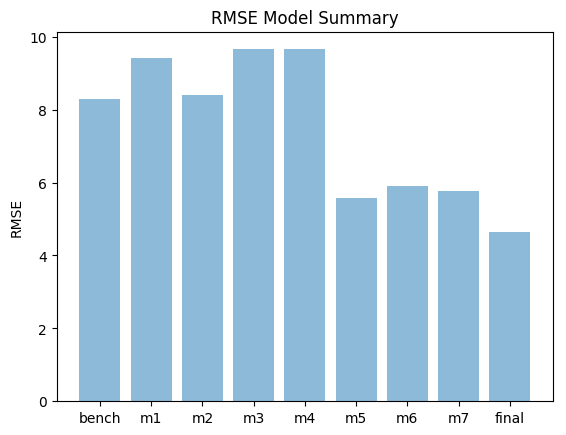

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

models = ('bench','m1', 'm2', 'm3', 'm4', 'm5', 'm6','m7', 'final')
y_pos = np.arange(len(models))
rmse = [8.29,9.431,8.408,9.657,9.657,5.588,5.906,5.759,4.653]

plt.bar(y_pos, rmse, align='center', alpha=0.5)
plt.xticks(y_pos, models)
plt.ylabel('RMSE')
plt.title('RMSE Model Summary')

plt.show()

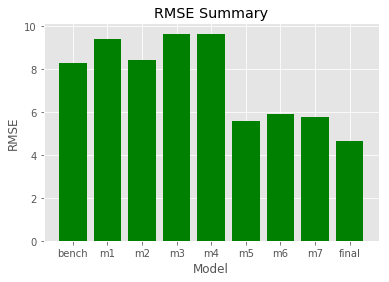

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['bench','m1', 'm2', 'm3', 'm4', 'm5', 'm6','m7', 'final']
RMSE = [8.29,9.431,8.408,9.657,9.657,5.588,5.906,5.759,4.653]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, RMSE, color='green')
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Model Summary")

plt.xticks(x_pos, x)

plt.show()

# CHALLENGE MODEL IS OPTIONAL
## Create a model that modifies the dayofweek.  NOTE: I need to add more instructions here.

In [17]:
%%bigquery
CREATE OR REPLACE MODEL feat_eng.challenge_model
TRANSFORM(fare_amount, 
    #SQRT( (pickuplon-dropofflon)*(pickuplon-dropofflon) + (pickuplat-dropofflat)*(pickuplat-dropofflat) ) AS euclidean, 
    #NOTE TO SELF AND PUT IN GEOLOCATION FEATURES
    ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) AS euclidean,
          IF(EXTRACT(dayofweek FROM pickup_datetime) BETWEEN 2 and 6, 'weekday', 'weekend') AS dayofweek,
    ML.BUCKETIZE(EXTRACT(HOUR FROM pickup_datetime), [5, 10, 17]) AS day_hr,
             CONCAT(
     ML.BUCKETIZE(pickuplon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(pickuplat, GENERATE_ARRAY(37, 45, 0.01)),
     ML.BUCKETIZE(dropofflon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(dropofflat, GENERATE_ARRAY(37, 45, 0.01))
  ) AS pickup_and_dropoff
)
OPTIONS(input_label_cols=['fare_amount'], model_type='linear_reg', l2_reg=0.1) 

AS
SELECT 
*
FROM  `feat_eng.feateng_training_data`

""


#### Exercise:  Create three SQL statements to EVALUATE the challenge model.

In [18]:
%%bigquery
SELECT *, SQRT(loss) AS rmse FROM ML.TRAINING_INFO(MODEL feat_eng.challenge_model)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,0,11.433265,22.693863,None,205132,3.381311


In [19]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.challenge_model)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.329029,22.693863,0.070851,1.415602,0.745014,0.745014


In [20]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.challenge_model)

,rmse
0,4.763808


In [16]:
%%bigquery
#PREDICTION on the CHALLENGE MODEL
#In this model, we do not show a pickup time because the bucketize has put pickup time in three buckets:
#5,10,17
#How do we not show pickup datetime?

SELECT * FROM ML.PREDICT(MODEL feat_eng.challenge_model, (
  SELECT 
    -73.982683 AS pickuplon,
    40.742104 AS pickuplat,
    -73.983766 AS dropofflon,
    40.755174 AS dropofflat,
    TIMESTAMP('2019-06-03 04:21:29.769443 UTC') AS pickup_datetime
))

,predicted_fare_amount,pickuplon,pickuplat,dropofflon,dropofflat,pickup_datetime
0,6.367442,-73.982683,40.742104,-73.983766,40.755174,2019-06-03 04:21:29.769443+00:00
